In [1]:
import numpy as np
import tonic.transforms as transforms
import tonic
from torchvision import transforms as tt
from torch.utils.data import Dataset, DataLoader
#from tonic.dataset import Dataset
from typing import Callable, Optional
import torch
from torch import nn

import matplotlib.pyplot as plt
from torchvision.ops import masks_to_boxes
from torchvision.utils import draw_bounding_boxes
from typing import Tuple
from tqdm.notebook import tqdm
from statistics import mean

import snntorch as snn

In [2]:
class EVIMOMask(Dataset):
    def __init__(self,
                 dir: str,
                 num_bins_per_frame: int,
                 output_size: Tuple,
                ):
        self.dir = dir
        self.num_bins_per_frame = num_bins_per_frame
        self.output_size = output_size
        self.length = np.load(self.dir + "/length.npy")

        
        #print(self.length)
        #self.start_idx = start_idx


    def __getitem__(self, index):
        item = np.load(self.dir + "/" + str(index) + ".npy", allow_pickle=True).tolist()


        events = np.asarray(item["events"])

        frame_transform = transforms.Compose([# transforms.Denoise(filter_time=0.01),
                                       transforms.ToVoxelGrid(sensor_size=sensor_size,
                                                          n_time_bins=self.num_bins_per_frame)
                                      ])

        events = frame_transform(events)

        mask = torch.from_numpy(np.asarray([item["mask"]])).to(torch.int64)

        one_hot_mask = torch.nn.functional.one_hot(mask, num_classes=num_classes).transpose(1, 3).transpose(2, 3) # Conversion into Batch, Channels, H, W

        # Downsize the mask.
        resized_mask = tt.functional.resize(one_hot_mask, self.output_size, antialias=True)
        
        return torch.from_numpy(events).to(torch.float), resized_mask.squeeze()

    def get_original_mask(self, index):
        item = np.load(self.dir + "/" + str(index) + ".npy", allow_pickle=True).tolist()
        mask = torch.from_numpy(np.asarray([item["mask"]])).to(torch.int64)
        return mask

    def __len__(self) -> int:
        return self.length # - self.start_idx

    def get_item(self, index):
        item = np.load(self.dir + "/" + str(index) + ".npy", allow_pickle=True).tolist()
        return item
    
    

In [3]:
num_bins_per_frame = 8 # T = 100
framerate = 200

sensor_size = [640, 480, 2]
output_size=(30, 40)
input_size=(480, 640)
num_classes = 25

dir = "./EVIMO/left_cam/scene14_test3"

In [4]:
dataset = EVIMOMask(dir=dir, output_size=output_size, num_bins_per_frame=num_bins_per_frame)

In [5]:
bins, mask = dataset[600]

In [6]:
bins.shape

torch.Size([8, 1, 480, 640])

In [7]:
mask.shape

torch.Size([25, 30, 40])

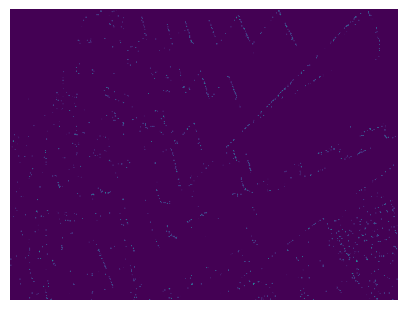

In [8]:
animation = tonic.utils.plot_animation(bins.numpy())
from IPython.display import HTML

HTML(animation.to_jshtml())

In [9]:
len(dataset)

1000